<a href="https://colab.research.google.com/github/kocurvik/BCS_results/blob/master/HUPV/notebooks/solutions/cv07_en_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1 - fine-tuning

You shold work on this exercise in the cloud. You can prepare it at home or in Colab. However, try running it on the cloud as well.

In this task, we will train a network with pre-trained weights called fine-tuning or transfer learning. We will take the pre-trained models from `torchvision.models` on the cats vs. dogs dataset, which you can download for example here:


```
https://files.fast.ai/data/examples/dogscats.tgz
```

or mirrors

```
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
https://www.kaggle.com/c/dogs-vs-cats
```


Use `torchvision.datasets.ImageFolder` to work with the dataset. Since the pre-trained model assumes that the input will be a normalized image, you must also use transformations in its constructor:

```python
from torchvision import transforms

transform = transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225] )
     ])
```


After loading the model, we must first change the dimension of its ouptut. We do this by changing its parameter fc layer so that there are only two neurons at the output (or one + sigmoid). If we want to freeze the layers, it is advisable to do it beforehand. Then we will only optimize the very last layer.

More detailed information which is also applicable for more complex tasks can be found in [the pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

```python
from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
     param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 2))

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
```

Then try to train the model in a standard training loop. Don't forget to put model.train() before the training loop and model.eval() before the validation loop! Otherwise it won't work.

## Exercise 2 - Visualization of Importatnt Parts of the Input

In this exercise we will try to verify which parts of the image are important for classification. We do this by taking a test image and finding its output classification. Then we will insert a black square in different places in the image. Then we find out how much the model's prediction has changed. We will then make a heatmap from these changes.

Use a pre-trained model and some random image from the internet. Of course, it will be necessary to apply transformations.

First, we will load some test images. In order to make our work easier, we will immediately reduce them to the size of 224 x 224 and convert them them to floats.

In [1]:
import cv2

test_imgs = []
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/magpie.jpg
test_imgs.append(cv2.resize(cv2.imread('magpie.jpg'),(224,224)) / 255)
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/bear.jpg
test_imgs.append(cv2.resize(cv2.imread('bear.jpg'),(224,224)) / 255)
!wget https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/car.jpg
test_imgs.append(cv2.resize(cv2.imread('car.jpg'),(224,224)) / 255)

--2023-10-19 14:34:40--  https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/magpie.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32497 (32K) [image/jpeg]
Saving to: ‘magpie.jpg’

magpie.jpg          100%[===================>]  31.74K  --.-KB/s    in 0.003s  

2023-10-19 14:34:40 (8.97 MB/s) - ‘magpie.jpg’ saved [32497/32497]

--2023-10-19 14:34:40--  https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/bear.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58473 (57K) [image/jpeg]


We display the images.

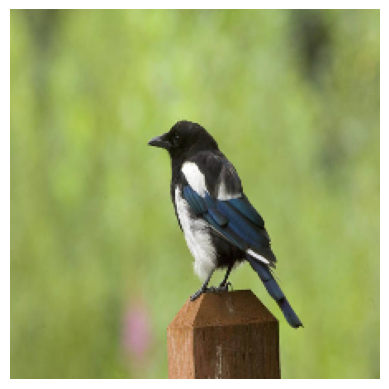

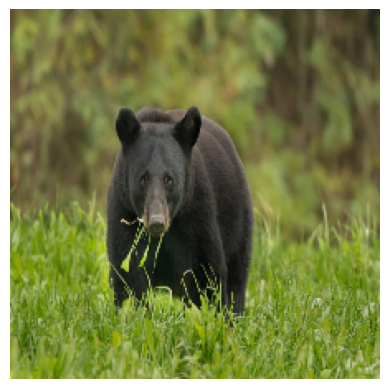

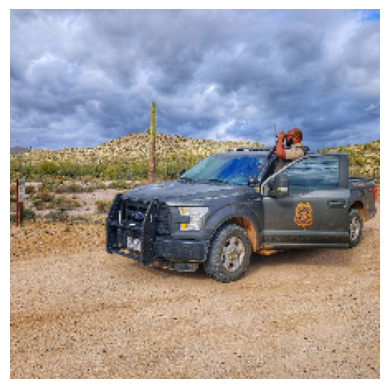

In [2]:
from matplotlib import pyplot as plt
for img in test_imgs:
  plt.imshow(img[:, :, ::-1])
  plt.axis('off')
  plt.show()

In [3]:
import torch
from torchvision import models, transforms

import numpy as np

If we want to process the image with the network we first need to swap the channel dimension and apply the normalization. We can verify that the network is working well by looking at the [imagenet class table](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


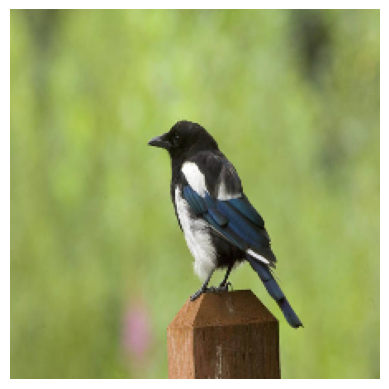

tensor(18, device='cuda:0')
tensor(19.7582, device='cuda:0', grad_fn=<MaxBackward1>)


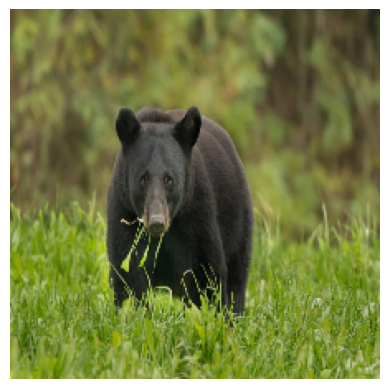

tensor(295, device='cuda:0')
tensor(22.5445, device='cuda:0', grad_fn=<MaxBackward1>)


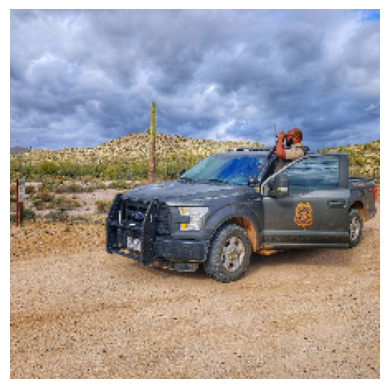

tensor(864, device='cuda:0')
tensor(8.5501, device='cuda:0', grad_fn=<MaxBackward1>)


In [4]:
from torchvision.transforms.functional import normalize

model = models.resnet18(pretrained=True).eval().cuda()


def prepare_for_model(img):
  img = np.transpose(img[:, :, ::-1], (2, 0, 1))[np.newaxis, ...].astype(np.float32)
  img_torch = torch.from_numpy(img)
  img_torch = normalize(img_torch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  return img_torch


for img in test_imgs:
  plt.imshow(img[:, :, ::-1])
  plt.axis('off')
  plt.show()
  out = model(prepare_for_model(img).cuda())
  print(torch.argmax(out))
  print(torch.max(out))

Implement the function `generate_heatmap` so that it returns a heatmap of size $rectangle\_num \times rectangle\_num$. The individual elements of the heatmap will represent how much the prediction for the original image class will change if we add a black square of size $rectangle\_size \times rectangle\_size$ to the corresponding place in the image. You can use `cv2.rectangle` or a similar method.

In the beginning, of course, you need to find out which class is predicted for the original image. Then we will always look at the value at the given index at the output. The more it decreases, the higher the value that we put in the heatmap. Thus, the heatmap will show us which parts are the most important for the network.

When implementing the function, try to take advantage of the fact that the model can process several images at once if you stack them "on top of each other" similarly to batches used during training.

In [5]:
def generate_heatmap(img, model, rectangle_num, rectangle_size):
  pred = model(prepare_for_model(img).cuda())
  class_id = torch.argmax(pred[0])
  print(class_id)

  heatmap = np.zeros([rectangle_num, rectangle_num])
  xs = np.linspace(0,224,rectangle_num)
  ys = np.linspace(0,224,rectangle_num)
  for idx_y, y in enumerate(ys):
    in_array = torch.zeros([rectangle_num, img.shape[2], 224, 224])
    for idx_x, x in enumerate(xs):
      c_img = test_img.copy()
      c_img = cv2.rectangle(c_img, (int(x - rectangle_size), int(y - rectangle_size)), (int(x + rectangle_size), int(y + rectangle_size)), (0, 0, 0), -1)
      c_img = prepare_for_model(c_img)
      in_array[idx_x] = c_img[0]
    pred = model(in_array.cuda())
    heatmap[idx_y, :] = 1 - pred[:, class_id].cpu().detach().numpy()
  return heatmap

The following code should generate the images of heatmaps.

tensor(18, device='cuda:0')


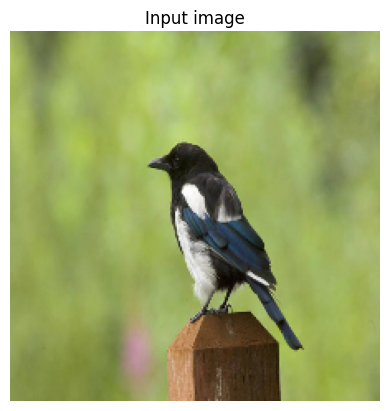

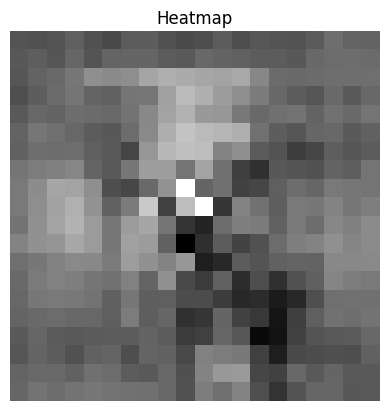

tensor(295, device='cuda:0')


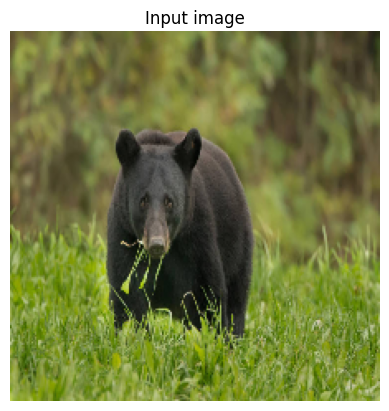

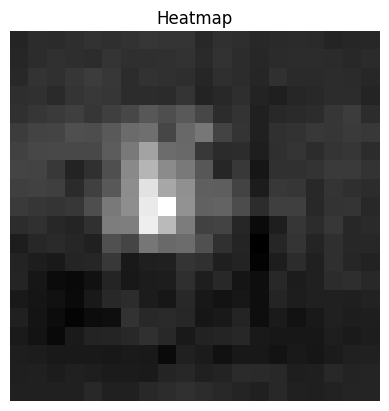

tensor(864, device='cuda:0')


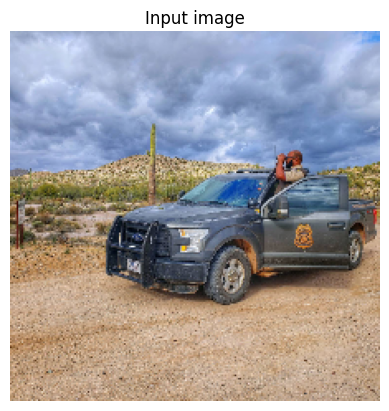

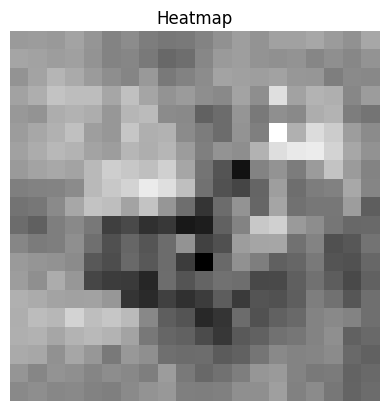

In [6]:
for test_img in test_imgs:
  hmap = generate_heatmap(test_img, model, 20, 9)
  plt.imshow(test_img[:,:,::-1])
  plt.axis('off')
  plt.title('Input image')
  plt.show()
  plt.imshow(hmap,cmap='gray')
  plt.title('Heatmap')
  plt.axis('off')
  plt.show()